# House Prices

Problem Statement - In this competition we have to predict House prices of test set by building a model using training set.

## Summary
* Libraries used : numpy, pandas, matplotlib, seaborn, sklearn, xgboost etc.
* Some of the important features are OverallQual, GrLivArea, GarageArea, GarageCars etc.
* For missing data both methods, Droping missing data and filling custom value using SimpleImputer are imployed.
* For Encoding categorical features both one hot Encoding and Label encoding are used.
* Target is transformed using natural log.
* XGBootRegressor model is used in this notebook.
* Model is optimized and evaluated using cross-validation and mean absolute error is used as error estimate.
* Public score of model is 0.12997.

XGBoostRegressor is a popular machine learning model for regression which is an implementation of Gradient boosted trees algorithm. It does not require much feature engineering or feature selection. It has many different parameters but I will be opptimizing only n_estimators and learning_rate as I am not very familier with XGBoosting.

## Steps
* Import Libraries
* Loading Data
* Data Preparation
  * Removing outliers
  * Transforming Target data
  * Missing data
  * Encoding Categorical features
* Modelling
* Prediction

# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/test.csv
/kaggle/input/house-prices-advanced-regression-techniques/train.csv


# Loading data

In [2]:
data_train = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv", index_col = "Id")
data_test = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv", index_col = "Id")
data_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# Data Preparation

In [3]:
# Searching for most related features among 79 features
corrs = data_train.corr()
corrs = corrs["SalePrice"].sort_values(ascending = False)
print(corrs.head())
print(corrs.tail())

SalePrice      1.000000
OverallQual    0.790982
GrLivArea      0.708624
GarageCars     0.640409
GarageArea     0.623431
Name: SalePrice, dtype: float64
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64


OverallQual, GrLivArea, GarageCars, GarageArea, are positively related features. There is no strong negatively related feature.

# Removing Outlier

I will be exploring outliers with respect to highly related features.

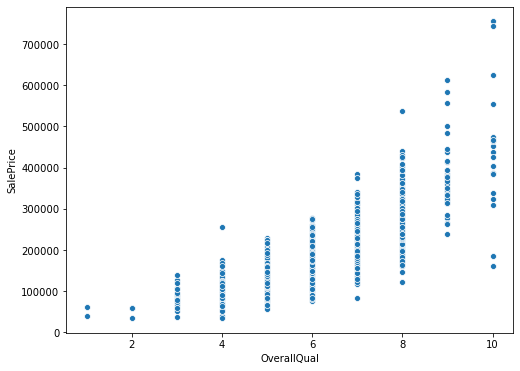

In [4]:
# OverallQual

plt.figure(figsize = (8,6))
sns.scatterplot(data = data_train, x="OverallQual", y="SalePrice")

We can see 4 point having "OverallQual" 10, of which 2 have very high price and 2 have very low price.

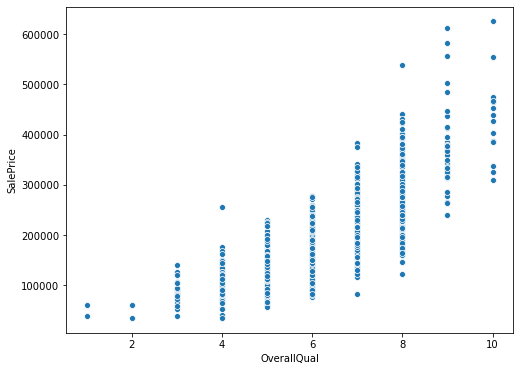

In [5]:
# Removing Outliers
data_train.drop(data_train[(data_train['OverallQual'] == 10) & ((data_train['SalePrice'] < 250000) | (data_train['SalePrice'] > 700000))].index, inplace = True)
plt.figure(figsize = (8,6))
sns.scatterplot(data = data_train, x="OverallQual", y="SalePrice")

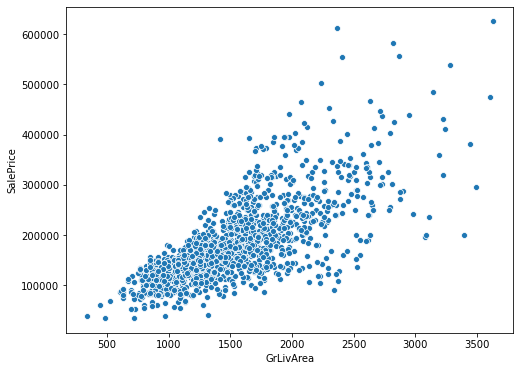

In [6]:
# GrLivArea

plt.figure(figsize = (8,6))
sns.scatterplot(data = data_train, x="GrLivArea", y="SalePrice")

It seem there is no outlier in above plot.

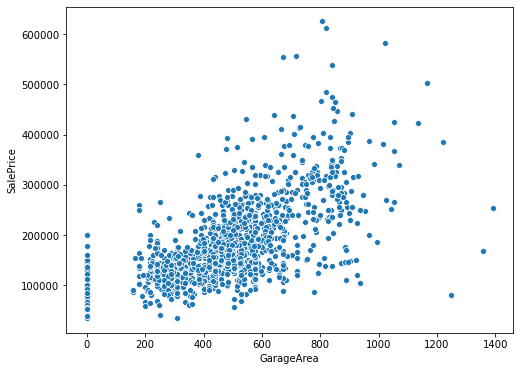

In [7]:
# GarageArea

plt.figure(figsize = (8,6))
sns.scatterplot(data = data_train, x="GarageArea", y="SalePrice")

We can see 3 points having large "GarageArea" but very less price.

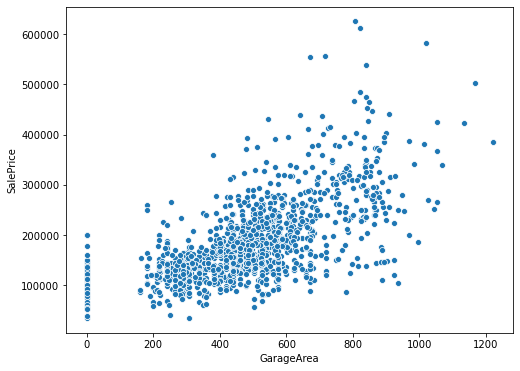

In [8]:
# Removing Outliers
data_train.drop(data_train[(data_train['GarageArea'] > 1200) & (data_train['SalePrice'] < 300000)].index, inplace = True)
plt.figure(figsize = (8,6))
sns.scatterplot(data = data_train, x="GarageArea", y="SalePrice")

# Transforming Target Data

I got this idea of transforming target from disscussions section of this competition. I know about transforming input features, but this is first time i heard of transforming target and using it. Also we have to transform back the result before submission.

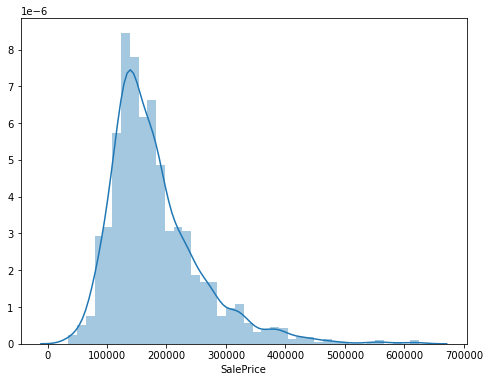

In [9]:
y_train = data_train["SalePrice"].copy()

plt.figure(figsize = (8,6))
sns.distplot(y_train)

It appears that target data is left skewed. Skewness does not make much difference in score when using boostedtree based model but in this competition, evaluation of test result will be done after taking log of output thus it can improve the score.

In [10]:
y_train.skew()

1.56842639470272

0.06748735917927763


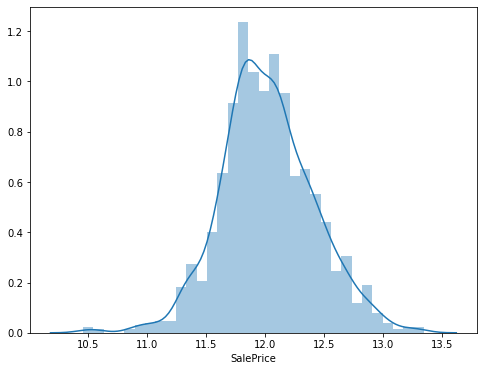

In [11]:
y_train = np.log(y_train)

print(y_train.skew())

plt.figure(figsize = (8,6))
sns.distplot(y_train)

# Missing Data

In [12]:
# Combining Train and Test data for processing
data = pd.concat([data_train.drop(columns = ["SalePrice"]),data_test])
data.shape

(2912, 79)

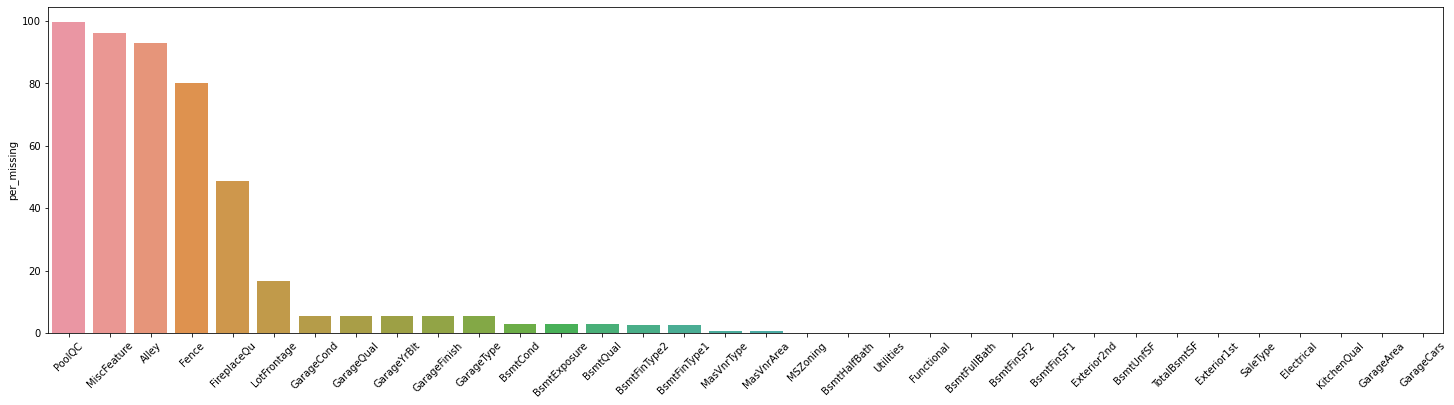

In [13]:
# Calculating percentage of missing data in every column
null_per = (data.isnull().sum()*100/2919).sort_values(ascending = False)
null_per = pd.DataFrame({"per_missing":null_per})
null_per = null_per[null_per["per_missing"] != 0]
plt.figure(figsize=(25,6))
plt.xticks(rotation = 45)
sns.barplot(data = null_per, x=null_per.index, y="per_missing")

Droping columns which contain missing values more than 40%. Also they doesn't appear to be important feature which affect prediction drastically.

In [14]:
drop_col = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu']
data.drop(columns = drop_col, inplace = True)
data.shape

(2912, 74)

Droping all garage related features except "GarageYrBlt" and "GarageArea". "GarageArea" and "GarageCars" are important features but they are highly correlated, there is no sense in using both of them. Thus either we can combine them to make one feature or drop any one of them. I will be droping "GarageCars".

In [15]:
drop_garage = ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'GarageCars']
data.drop(columns = drop_garage, inplace = True)

data['GarageYrBlt'] = np.where(data['GarageYrBlt'].isnull(), data['YearBuilt'], data['GarageYrBlt'])

# filling zero because if there is no entry in "GarageArea", then there is no garage ie zero area
data['GarageArea'].fillna(0, inplace = True)
data.shape

(2912, 69)

In [16]:
# filling "None" in categorical feature and zero in numerical feature missing values of Basement related features

bsmt_col = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']

for col in bsmt_col:
    if data[col].dtype == 'object':
        data[col].fillna('None', inplace = True)
    else:
        data[col].fillna(0, inplace = True)

In [17]:
null_per = (data.isnull().sum()*100/2919).sort_values(ascending = False)
null_per = pd.DataFrame({"per_missing":null_per})
null_per = null_per[null_per["per_missing"] != 0]
null_per

,per_missing
LotFrontage,16.615279
MasVnrType,0.822199
MasVnrArea,0.787941
MSZoning,0.137033
Utilities,0.068517
Functional,0.068517
SaleType,0.034258
KitchenQual,0.034258
Exterior1st,0.034258
Exterior2nd,0.034258


Using SimpleImputer for remaining missing data. Here SimpleImputer is trained through training data to avoid any data leakage ie. information leak from test set to training set. Test set should be unseen to training set for generalization of model.  

In [18]:
from sklearn.impute import SimpleImputer

cols = ['LotFrontage', 'MasVnrType', 'MasVnrArea', 'MSZoning', 'Utilities', 'Functional', 'SaleType', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'Electrical']

for col in cols:
    if data[col].dtype == 'object':
        imputer = SimpleImputer(strategy = "most_frequent")
        imputer.fit(data_train[[col]])
        data[col] = imputer.transform(data[[col]])  # mode for categorical features
    else:
        imputer = SimpleImputer()
        imputer.fit(data_train[[col]])
        data[col] = imputer.transform(data[[col]])  # mean for numerical features

null_per = (data.isnull().sum()*100/2919)
null_per.sum()

0.0

# Encoding Categorical features

I will be using one hot encoding for features containing 5 or less than 5 labels and Label encoding for remaining features.

In [19]:
OH_cat_cols = []
lab_cat_cols = []
for col in data.columns:
    if data[col].dtype == 'object':
        if data[col].nunique() <= 5:
            OH_cat_cols.append(col)
        else:
            lab_cat_cols.append(col)
print(len(OH_cat_cols),len(lab_cat_cols))

19 15


**One Hot Encoding**

In [20]:
OH_cols = pd.get_dummies(data[OH_cat_cols])
data.drop(columns = OH_cat_cols, inplace = True)
data = pd.concat([data,OH_cols], axis = 1)
data.shape

(2912, 127)

**Label Encoding**

In [21]:
from sklearn.preprocessing import OrdinalEncoder

lab_encoder = OrdinalEncoder()
data[lab_cat_cols] = lab_encoder.fit_transform(data[lab_cat_cols])

# cheching if all are numerical or not
print("any object data type:",bool((data.dtypes == "object").sum()))

any object data type: False


Separating Train and Test set.

In [22]:
X_train = data[:data_train.shape[0]]
X_test = data[data_train.shape[0]:]
print(X_train.shape,data_train.shape,y_train.shape)
print(X_test.shape,data_test.shape)

(1453, 127) (1453, 80) (1453,)
(1459, 127) (1459, 79)


# Modelling

I will be using XGBRegressor Model.

In [23]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

model_1 = XGBRegressor().fit(X_train, y_train, verbose = False)
predict_1 = model_1.predict(X_train)
error = 1000 * mean_absolute_error(predict_1,y_train)
error

7.623632565256028

Using cross validation to optimize model. I will be optimizing through only n_estimators and learning_rate parameters.
For optimising GridSearchCV can also be used in place of nested for loop but it return only best model, I will also use second and third best model as there is very less difference in there errors.

In [24]:
from sklearn.model_selection import cross_val_score

for est in [70, 100, 150, 250, 500, 800, 1000, 1500]:
    print("n_est {}".format(est))
    for rate in [0.01, 0.025, 0.05, 0.1, 0.2]:
        xgb = XGBRegressor(n_estimators = est, learning_rate = rate)
        score = (-1000/5) * cross_val_score(xgb, X_train, y_train, scoring = "neg_mean_absolute_error", cv = 5).sum()
        print(rate,score)

n_est 70
0.01 5707.121229221118
0.025 1963.905954379815
0.05 331.3885304251578
0.1 87.92740541372692
0.2 91.1245783953624
n_est 100
0.01 4223.479559833943
0.025 921.7028301571
0.05 113.39169427848137
0.1 85.50039109833332
0.2 90.83139188790264
n_est 150
0.01 2557.5491054258755
0.025 274.17497584717364
0.05 85.39495079347294
0.1 85.00468944967852
0.2 90.64146211876238
n_est 250
0.01 939.586399726182
0.025 90.08007293083458
0.05 83.0045178830663
0.1 84.77392877953537
0.2 90.55987085040712
n_est 500
0.01 118.18508194935073
0.025 82.79039416849572
0.05 82.52989673442063
0.1 84.73889164273984
0.2 90.57063028111625
n_est 800
0.01 84.59599621134845
0.025 82.2996492151219
0.05 82.71016755538895
0.1 84.73719707977119
0.2 90.57063028111625
n_est 1000
0.01 83.23263338133128
0.025 82.38821385620226
0.05 82.74297904561784
0.1 84.73719707977119
0.2 90.57063028111625
n_est 1500
0.01 82.3759173670123
0.025 82.35474196248755
0.05 82.74899424435237
0.1 84.73719707977119
0.2 90.57063028111625


**Final Model**

Training using whole Training data.

In [25]:
fmodel = XGBRegressor(n_estimators = 800, learning_rate = 0.025).fit(X_train, y_train, verbose = False)
fpredict = fmodel.predict(X_train)
ferror = 1000*mean_absolute_error(fpredict, y_train)
ferror

18.353271396891532

# Prediction

In [26]:
test_pred = fmodel.predict(X_test)
final = pd.DataFrame({"Id":X_test.index, "SalePrice":np.exp(test_pred)})  # retransforming predictions
final.head()

,Id,SalePrice
0,1461,123447.562500
1,1462,162540.734375
2,1463,187883.171875
3,1464,187583.265625
4,1465,186448.953125


In [27]:
final.tail()

,Id,SalePrice
1454,2915,75711.757812
1455,2916,84064.476562
1456,2917,170141.375000
1457,2918,113963.101562
1458,2919,211118.062500


Saving predictions.

In [28]:
final.to_csv('./submission5.csv', index=False)